# Abstract  

K-means is one of the most common data processing algorithms. The algorithms obtain an excellent final solution by employing proper initialization. However, from a theoretical perspective concerning quality and efficiency, k-means is not a suitable clustering algorithm. This is because in the worst case it produces a final solution which is locally optimal, although it doesn't meet the typical global optimum. Besides, this paper will discuss the keys that were applied in the process improving k-means from traditional to the current modern algorithm. The big step taken was to develop the initialization procedure of traditional k-means which changed the performance of Lloyd's iteration. The improvement resulted in k-means++ algorithm which improves upon the running time of iteration. The algorithm picks only the first cluster center consistently at random from the data and probability is used in selecting the subsequent cluster center. Initialization of k-means++ leads to an O(log K) which is an approximation of the solution optimum. However, K-means++ algorithm has its downside which is being intrinsically sequential. Although it has a total running of 0(nkd), its k-clustering is similar to that of a single Lloyd's iteration. The downside led to obtainment a parallel version of k-means++ known as k-means||. The k-means|| algorithm uses the idea of sampling O(k) points per round, and the process is repeated to O(log n) rounds. Moreover, at the end the algorithm only O(k log n) points are left, which form a solution in a constant factor.

# 1. Background

In data mining and processing, some specifics algorithms are applied to cluster or group the data to meaningful information. Those algorithms are referred as clustering algorithms. In this case, scalable k-means paper is used in the research about of k-means algorithms, their efficiency in operation and the solution they offer in data mining processes. K-means clustering algorithms are used when data is unbalanced that is data without defined groups or categories (Bahmani, Moseley, Vattani, Kumar & Vassilvitskii, 2012). These algorithms aim to group data into clusters whereby variable k represents the number of groups or cluster. Besides, the algorithm works iteratively to allocate every data point to a single k group by use of provided attributes. It should be noted that data points are clustered on the ground of feature similarity. K-means results in centroids of the k clusters that are used in new data labeling and markers for the training data.

# 2. Application of the Algorithm

The k-means algorithm can be useful in almost all the fields. The algorithm is used in data clustering applications in different areas (Bahmani, Moseley, Vattani, Kumar & Vassilvitskii, 2012). For instance, clustering helps marketers advance their customers base as well as work on the goal areas. The k-means help group people using different criteria including purchasing power and willingness. The grouping is on the basis of their similarity in several ways which are related to the product under deliberation. In addition, clustering can be used to study earthquake. K-means analyses shows the next likely location where an earthquake can transpire by use of available data on the areas hit by the quake in a region. Moreover, k-means algorithm is mostly applied in large database management systems whereby data is mined, cleaned and analyzed for useful information. The advantage of k-means is that it is computationally faster than other clustering algorithms such as hierarchical clustering algorithm. The main disadvantage is that k-means cannot grip non-globular data of diverse sizes and densities.

# 3. Implementation 

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.spatial.distance as dist
import collections 
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans


In [50]:
def timer(f, *args, **kwargs):
    '''
    Function to determine the running time of a function
    Input: A function, f. The arguments for f
    Output: The running time of f
    '''
    start = time.clock()
    ans = f(*args, **kwargs)
    return time.clock() - start

## 3.1 Kmeans

### 3.1.1 Algorithm

**Initialize cluster centroids $\mu_1, \mu_2....\mu_k \in \mathbb{R}^n$ randomly** <br>
Repeat until convergence:{<br> 
+ For every i, set <br>
> $c^{(i)}:= argmin||x^{(i)} - u_j||^2$  <br>
+ For every j, set<br>
> $\mu_j := \frac{\sum_{i=1}^{m} 1 \{c^{(i) = j}\}x^{(i)}}{\sum_{i=1}^{m} 1\{c^{(i) = j}\}}$<br>

}

### 3.1.2 Code

In [67]:
def distance(X, Y):
    dist = np.empty((X.shape[0], Y.shape[0]), dtype=np.float)
    for k in range(X.shape[0]):
        for i in range(Y.shape[0]):
            temp = 0
            for j in range(X.shape[1]):
                temp = temp +(X[k,j] - Y[i,j])**2
            dist[k, i]= temp**0.5
    return dist

In [163]:
def kmeans(data, k, centroids, max_iter=10000):
    
    for i in range(max_iter):
        cdist = (distance(data, centroids))**2
        labels = np.argmin(cdist, axis=1)
        update_centroids = np.zeros(centroids.shape)
        for j in range(k):
            # check if the centroid is the closest to some data point
            if sum(labels == j) != 0:
                update_centroids[j] = np.mean(data[labels ==j], axis=0)
            else:
                # if not, leave the lone centroid unmoved
                update_centroids[j] = centroids[j]
                
        if np.allclose(update_centroids, centroids):
            print("Algorithm converged after", i, "iterations.")
            return ({"Centroids": centroids, 
                      "Labels": labels})
        else:
            centroids = update_centroids
        
    print("Warning: maximum number of iterations reached. Failed to converge.")
    return({"Centroids": centroids, 
            "Labels": labels})

#### Random initial centroids

In [152]:
def main():
    k, n, d = 20, 1000, 15
    
    mean, cov = np.zeros(d), np.eye(d)
    data = np.random.multivariate_normal(mean, cov, n)
    #random initial 
    initial_centers = np.random.multivariate_normal(mean, cov, k)
    
    centroids = kmeans(data, k, initial_centers)

if __name__ == '__main__':
    main()


Algorithm converged after 24 iterations.


## 3.2 Kmeans++

### 3.2.1 Algorithm

**Choose the centers one by onte in a controlled fasion, where the current set of chosen centers will stochastically bias the choice of the next center**<br>

First sample a point uniformly at random from X : C<br>
Set how many clusters are needed: k <br>
Distance between points and centers: $d^2(x, C)$<br>
Compute the cost of X: $\phi x(C) = \sum_{x\in X} min_{i=1,..k} ||y - c_i||^2$<br>
While |C| < k do:
+ Sample x $\in$ X with probability $p_x = \frac{d^2(x, C)}{\phi x(C)}$ <br>
+ Stack C with {x}: C = C $\cup$ {x} <br> 

end while

### 3.2.1 Code

In [169]:
def kmeans_pp(data, k, weights):
    first_random = np.random.choice(data.shape[0], 1)
    C = data[first_random, :]
    
    for i in range(k-1):
        cdist = (distance(data, C))**2
        cdist_min = np.min(cdist, axis = 1)* weights
        prob = cdist_min/np.sum(cdist_min)
        new_center = np.random.choice(data.shape[0],1, p=prob)
        C = np.vstack([C, data[new_center,:]])
        
    return C

#### Equal weights for kmenas++

In [170]:
def main():
    k, n, d = 20, 1000, 15
    
    mean, cov = np.zeros(d), np.eye(d)
    data = np.random.multivariate_normal(mean, cov, n)
    #equal weights for kmenas++
    initial_centers = kmeans_pp(data, 20, 1)
    
    centroids = kmeans(data, k, initial_centers)

if __name__ == '__main__':
    main()

Algorithm converged after 27 iterations.


## 3.3 Kmeans_II

### 3.3.1 Algorithm

**Parallel version of Kmeans++**<br>

First set an oversampling factor l = $\Omega(K)$<br>
Sample a point uniformly at random from X : C<br>
Set how many clusters are needed: k <br>
Distance between points and centers: $d^2(x, C)$<br>
Compute the cost of X: $\phi x(C) = \sum_{x\in X} min_{i=1,..k} ||y - c_i||^2$<br>

for O(log($\phi$)) times do:
+ Sample each point x $\in$ X independently with probability $p_x = \frac{l * d^2(x, C)}{\phi x(C)}$ <br>
+ Stack C with {x}: C = C $\cup$ {x} <br> 

end for<br>
For each point x$\in$ C, compute $w_x$ to be the number of points in X closer than other points in C<br>
Recluster the weighted points in C into k clusters. 

### 3.3.2 Code

#### Compute each weight

In [171]:
def get_weight(C, data): 
    weights=np.zeros(C.shape[0])
    cdist = (distance(data,C))**2
    min_cdist = np.argmin(cdist, axis = 1)
    count = collections.Counter(min_cdist) 
    weights = list(collections.OrderedDict(sorted(count.items(), key=lambda x: x[0])).values())
    weights=np.array(weights)/sum(weights)
    return weights

In [172]:
def kmeans_II(data, k, l, max_iter=10000):
    first_random = np.random.choice(data.shape[0], 1)
    C = data[first_random, :]
    
    cdist = (distance(data, C))**2
    cdist_min = np.min(cdist, axis = 1)
    cost_phi = np.sum(cdist_min)
    
    for i in range(int(round(np.log(cost_phi)))):
        cdist = (distance(data, C))**2
        cdist_min = np.min(cdist, axis = 1)
        prob = cdist_min * l/np.sum(cdist_min)
        for j in range(data.shape[0]):
            if np.random.uniform() <= prob[j] and data[j,:] not in C:
                C = np.vstack([C, data[j,:]])
   
    weights= get_weight(C, data)

    return kmeans_pp(C, k, weights)
    

#### Initial centroids with weights

In [58]:
def main():
    k, n, d = 20, 1000, 15
    
    mean, cov = np.zeros(d), np.eye(d)
    data = np.random.multivariate_normal(mean, cov, n)
    #initial with weight 
    initial_centers = kmeans_II(data, 20, 10)
    
    centroids = kmeans(data, k, initial_centers)

if __name__ == '__main__':
    main()

Algorithm converged after 25 iterations.


# 5. Optimization

## 5.1 JIT Implementation

In [17]:
import numba
from numba import jit

Since in the normal version, I use the cdist function from python. In order to use jit, I need to rewrite the distance function.

In [174]:
@jit 
def jit_distance(X, Y):
    dist = np.empty((X.shape[0], Y.shape[0]), dtype=np.float)
    for k in range(X.shape[0]):
        for i in range(Y.shape[0]):
            temp = 0
            for j in range(X.shape[1]):
                temp = temp +(X[k,j] - Y[i,j])**2
            dist[k, i]= temp**0.5
    return dist

### 5.1.1 Kmeans

In [175]:
@jit 
def jit_kmeans(data, k, centroids, max_iter=10000):
    
    for i in range(max_iter):
        cdist = (jit_distance(data, centroids))**2
        labels = np.argmin(cdist, axis=1)
        update_centroids = np.zeros(centroids.shape)
        for j in range(k):
            # check if the centroid is the closest to some data point
            if sum(labels == j) != 0:
                update_centroids[j] = np.mean(data[labels ==j], axis=0)
            else:
                # if not, leave the lone centroid unmoved
                update_centroids[j] = centroids[j]
                
        if np.allclose(update_centroids, centroids):
            print("Algorithm converged after", i, "iterations.")
            return ({"Centroids": centroids, 
                      "Labels": labels})
        else:
            centroids = update_centroids
        
    print("Warning: maximum number of iterations reached. Failed to converge.")
    return ({"Centroids": centroids, 
                      "Labels": labels})

### 5.1.2 Kmeans++

In [176]:
@jit 
def jit_kmeans_pp(data, k, weights):
    first_random = np.random.choice(data.shape[0], 1)
    C = data[first_random, :]
    
    for i in range(k-1):
        cdist = (jit_distance(data, C))**2
        cdist_min = np.min(cdist, axis = 1)* weights
        prob = cdist_min/np.sum(cdist_min)
        new_center = np.random.choice(data.shape[0],1, p=prob)
        C = np.vstack([C, data[new_center,:]])
        
    return C


### 5.1.3 Kmeans_II

In [177]:
@jit
def jit_get_weight(C, data): 
    weights=np.zeros(C.shape[0])
    cdist = (jit_distance(data,C))**2
    min_cdist = np.argmin(cdist, axis = 1)
    count = collections.Counter(min_cdist) 
    weights = list(collections.OrderedDict(sorted(count.items(), key=lambda x: x[0])).values())
    weights=np.array(weights)/sum(weights)
    return weights


In [178]:
@jit
def jit_kmeans_II(data, k, l, max_iter=10000):
    first_random = np.random.choice(data.shape[0], 1)
    C = data[first_random, :]
    
    cdist = (jit_distance(data, C))**2
    cdist_min = np.min(cdist, axis = 1)
    cost_phi = np.sum(cdist_min)
    
    for i in range(int(round(np.log(cost_phi)))):
        cdist = (jit_distance(data, C))**2
        cdist_min = np.min(cdist, axis = 1)
        prob = cdist_min * l/np.sum(cdist_min)
        for j in range(data.shape[0]):
            if np.random.uniform() <= prob[j] and data[j,:] not in C:
                C = np.vstack([C, data[j,:]])
   
    weights= get_weight(C, data)

    return jit_kmeans_pp(C, k, weights)


## 5.2 cdist Implementation

### 5.2.1 Kmeans

In [179]:
def cdist_kmeans(data, k, centroids, max_iter=10000):
    
    for i in range(max_iter):
        cdist = (dist.cdist(data, centroids))**2
        labels = np.argmin(cdist, axis=1)
        update_centroids = np.zeros(centroids.shape)
        for j in range(k):
            # check if the centroid is the closest to some data point
            if sum(labels == j) != 0:
                update_centroids[j] = np.mean(data[labels ==j], axis=0)
            else:
                # if not, leave the lone centroid unmoved
                update_centroids[j] = centroids[j]
                
        if np.allclose(update_centroids, centroids):
            print("Algorithm converged after", i, "iterations.")
            return ({"Centroids": centroids, 
                      "Labels": labels})
        else:
            centroids = update_centroids
        
    print("Warning: maximum number of iterations reached. Failed to converge.")
    return centroids

### 5.2.2 Kmeans++

In [180]:
def cdist_kmeans_pp(data, k, weights):
    first_random = np.random.choice(data.shape[0], 1)
    C = data[first_random, :]
    
    for i in range(k-1):
        cdist = (dist.cdist(data, C))**2
        cdist_min = np.min(cdist, axis = 1)* weights
        prob = cdist_min/np.sum(cdist_min)
        new_center = np.random.choice(data.shape[0],1, p=prob)
        C = np.vstack([C, data[new_center,:]])
        
    return C

### 5.2.3 Kmeans_II

In [181]:
def cdist_get_weight(C, data): 
    weights=np.zeros(C.shape[0])
    cdist = (dist.cdist(data,C))**2
    min_cdist = np.argmin(cdist, axis = 1)
    count = collections.Counter(min_cdist) 
    weights = list(collections.OrderedDict(sorted(count.items(), key=lambda x: x[0])).values())
    weights=np.array(weights)/sum(weights)
    return weights

In [182]:
def cdist_kmeans_II(data, k, l, max_iter=10000):
    first_random = np.random.choice(data.shape[0], 1)
    C = data[first_random, :]
    
    cdist = (dist.cdist(data, C))**2
    cdist_min = np.min(cdist, axis = 1)
    cost_phi = np.sum(cdist_min)
    
    for i in range(int(round(np.log(cost_phi)))):
        cdist = (dist.cdist(data, C))**2
        cdist_min = np.min(cdist, axis = 1)
        prob = cdist_min * l/np.sum(cdist_min)
        for j in range(data.shape[0]):
            if np.random.uniform() <= prob[j] and data[j,:] not in C:
                C = np.vstack([C, data[j,:]])
   
    weights= get_weight(C, data)

    return jit_kmeans_pp(C, k, weights)

## 5.3: Parallel Implementation

In [48]:
import multiprocessing as mp

# 6. Applications

In [121]:
def time_compare(data, k, l):
    
    
    kmeans_pp_time = timer(kmeans_pp, data, k, 1)
    jit_kmeans_pp_time = timer(jit_kmeans_pp, data, k, 1)
    cdist_kmeans_pp_time = timer(cdist_kmeans_pp, data, k, 1)
    
    kmeans_II_time = timer(kmeans_II, data, k, l, max_iter = 10000)
    jit_kmeans_II_time = timer(jit_kmeans_II, data, k, l, max_iter = 10000)
    cdist_kmeans_II_time = timer(cdist_kmeans_II, data, k, l, max_iter = 10000)
        
    return pd.DataFrame([[kmeans_pp_time, kmeans_II_time],[jit_kmeans_pp_time, jit_kmeans_II_time],
                        [cdist_kmeans_pp_time, cdist_kmeans_II_time]], index = ["Original","JIT", "cdist"],
                        columns = ["k-means++","k-means||"])

## 6.1 Applications to simulated data sets

### 6.1.1 Simulate Data

#### Generate Random Data

In [216]:
def generate_data(k, n, feature_n, var = 10):
    
    #sample k centers 
    k_centers = np.random.multivariate_normal(np.zeros(feature_n),  np.eye(feature_n)*var, k)
    
    step=round(n/k)
    points=np.ones([step*k,15])
    
    for i in range(k):
        newpoints = np.random.multivariate_normal(k_centers[i],np.eye(feature_n),size = round(n/k))
        points[i*(step):(i*(step)+(step)),:] = newpoints
        if i == 0:
            true_labels = np.repeat(i,int(n/k+n%k))
        else: 
            true_labels = np.append(true_labels,np.repeat(i,int(n/k)))
    
    points=np.append(points, k_centers,axis = 0)
    #np.random.shuffle(points)
    return (points, k_centers, true_labels)

#### Generate gaussian mixuture dataset with 100000 observations, 10 groups and 10 variance

In [187]:
def navie_result(data, k, l):
    
    #find the initial center
    c  = np.random.choice(np.arange(len(data)), k)
    #base
    c0 = np.empty([k, data.shape[1]])
    c1 = data[c,:]
    c2 = cdist_kmeans_pp(data, k, 1)
    c3 = cdist_kmeans_II(data, k, l, max_iter = 10000)
    
    initial_centroid = np.array([c0, c1, c2, c3])
    
    
    label = np.empty([data.shape[0]])
    final_centroid = np.empty([k, data.shape[1]])
    for i in np.arange(1, 4):#three algorithm
        #kmeans_label = KMeans(n_clusters = k, init = initial_centroid[i], n_init = 1).fit_predict(data)
        output = cdist_kmeans(data,k ,initial_centroid[i])
        kmeans_label = output["Labels"]
        label = np.vstack([label, kmeans_label])
        kmeans_centroid = output["Centroids"]
        final_centroid = np.dstack((final_centroid, kmeans_centroid))

    
    return {"Initial_centroid":initial_centroid, "label":label, "Final_centroidtroid" :final_centroid }


In [191]:
k = 10
n = 10000
feature_n = 15
var = 10
l = 10
data_ful = generate_data(k, n, feature_n, var)
data=data_ful[0] 
dict = navie_result(data, k, l)

Algorithm converged after 14 iterations.
Algorithm converged after 17 iterations.
Algorithm converged after 1 iterations.


### 6.1.2 Show plot

In [192]:
def test_cluster(ini_cen, fin_cen, label, data, title): 
    plt.scatter(data[:, 0], data[:, 1], c = label)
    for i in range(np.unique(label).size):
        if i > 0:
            plt.scatter(ini_cen[i,0],ini_cen[i,1],marker = '+', c = 'red', s= 100)
            plt.scatter(fin_cen[i,0],fin_cen[i,1],marker = '*', c = 'blue', s= 100)
        else:
            plt.scatter(ini_cen[i,0],ini_cen[i,1],marker = '+', c = 'red', s= 100, label = "Initial Cluster")
            plt.scatter(fin_cen[i,0],fin_cen[i,1],marker = '*', c = 'blue', s= 100, label = "Final Cluster")
    
    plt.legend(loc='best', prop={'size':15})
    plt.title(title)

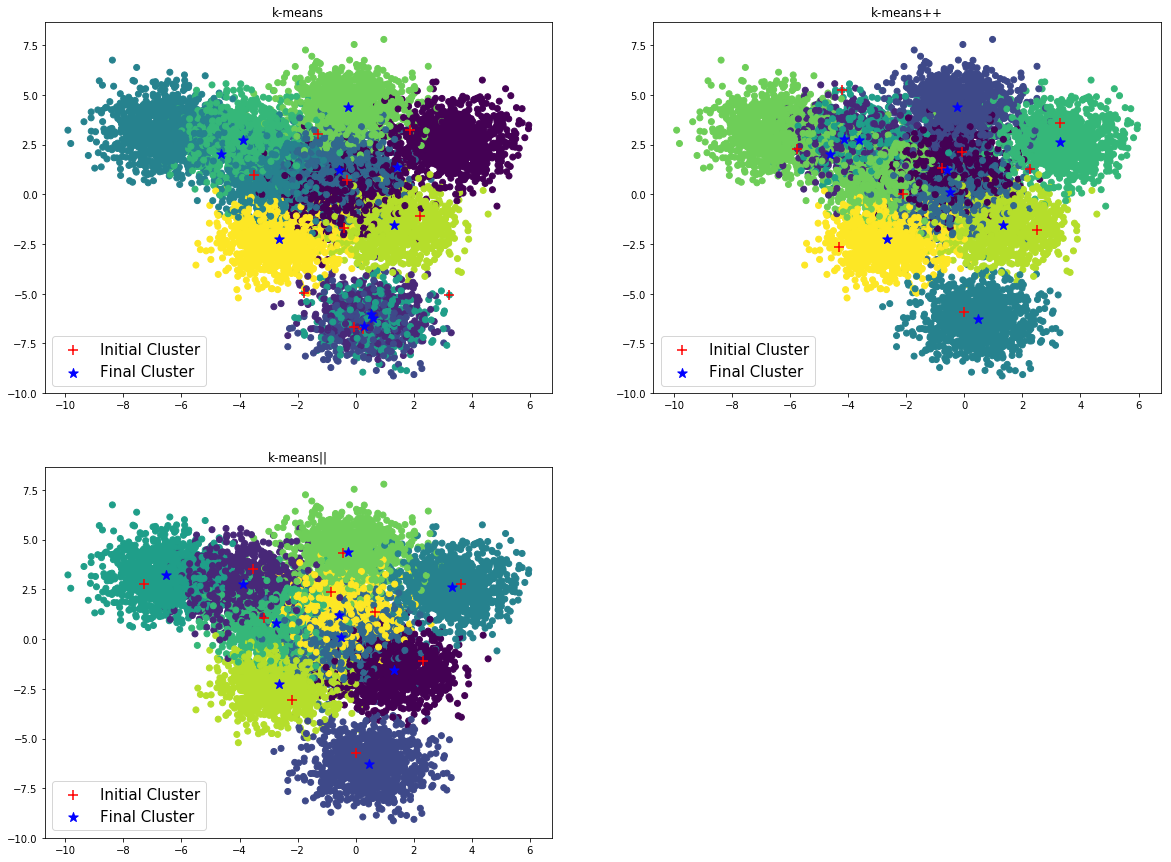

In [193]:
title = ["k-means", "k-means++", "k-means||"]
plt.figure(1, figsize=(20, 15))
for i in np.arange(1, 4):
    plt.subplot(220 + i)
    test_cluster(dict['Initial_centroid'][i], dict['Final_centroidtroid'][:,:,i], dict['label'][i],data, title[i - 1])
plt.show()

### 6.1.3 Time Efficiency

In [122]:
df_simu = time_compare(data, k, l)
df_simu

,k-means++,k-means||
Original,4.719786,125.749379
JIT,0.008956,16.338780
cdist,0.007883,18.290704


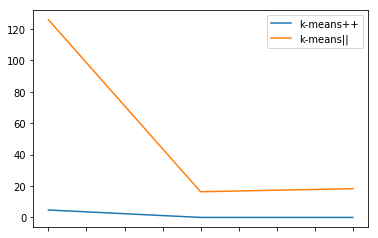

In [124]:
plt.figure(); 
df_simu.plot();
pass

### 6.1.4 Cost

In [241]:
def Cost(data,predict):
    dist = distance(data,predict)
    cost = np.sum(np.min(dist,axis=1))
    return cost/(data.shape[0])

In [251]:
print("Cost for random generated data")
random = Cost(data[:-10], dict["Final_centroidtroid"][:,:,1])
kmeans_pp_cost = Cost(data[:-10], dict["Final_centroidtroid"][:,:,2])
kmeans_II_cost = Cost(data[:-10], dict["Final_centroidtroid"][:,:,3])

pd.DataFrame([[random],[kmeans_pp_cost],
                        [kmeans_II_cost]], index = ["random","k-means++", "k-means"],
                        columns = ["Cost"])

Cost for random generated data


,Cost
random,13.578133
k-means++,13.754368
k-means,13.710473


## 6.2 Applications to real data sets - Spam base

### 6.2.1 Read data 

In [253]:
spambase = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data", header=None)

In [254]:
spambase.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


### 6.1.2 Show plot

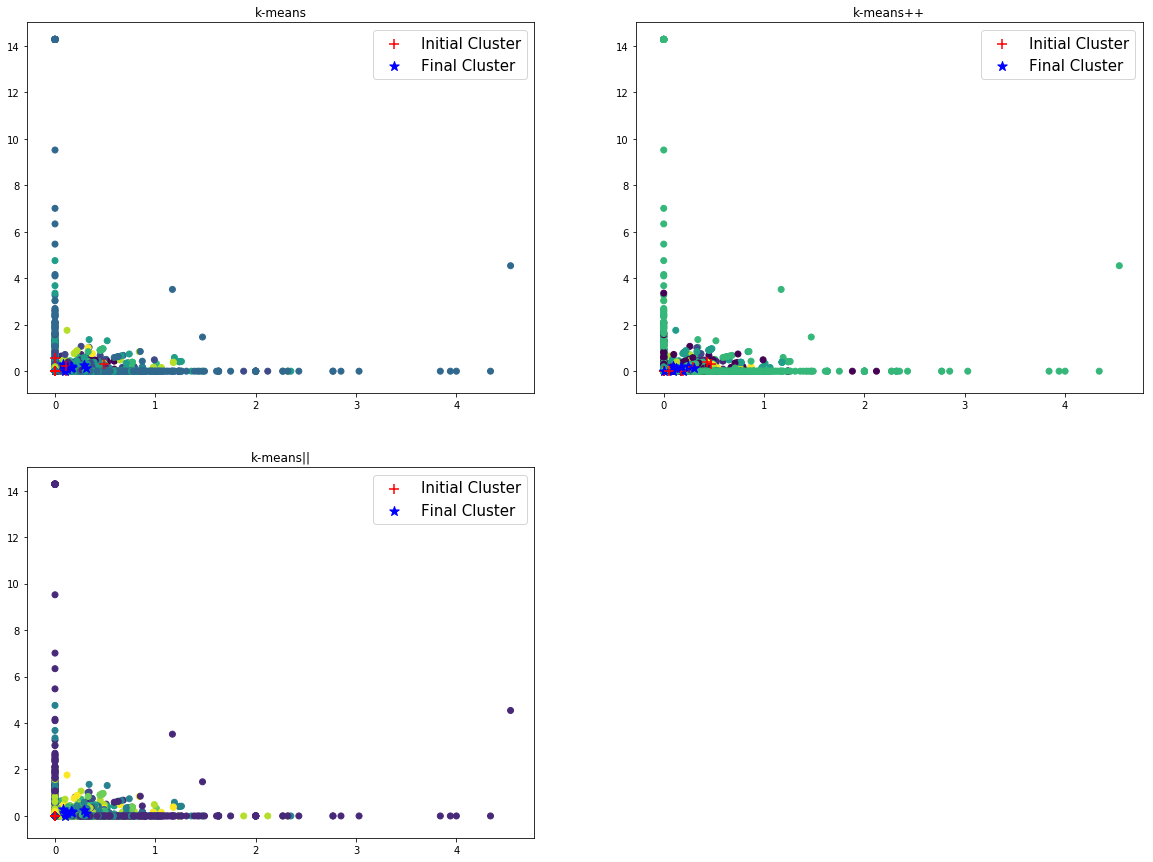

In [260]:
title = ["k-means", "k-means++", "k-means||"]
plt.figure(1, figsize=(20, 15))
for i in np.arange(1, 4):
    plt.subplot(220 + i)
    test_cluster(dict2['Initial_centroid'][i], dict2['Final_centroidtroid'][:,:,i], dict2['label'][i], spambase, title[i - 1])
plt.show()

### 6.2.3 Time Efficiency

In [255]:
spambase = np.asarray(spambase)
df_spambase = time_compare(spambase, k, l)
df_spambase

,k-means++,k-means||
Original,7.673385,3.923813
JIT,0.808934,0.947283
cdist,0.023902,0.304799


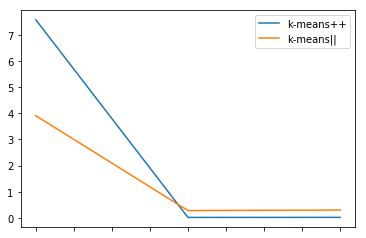

In [113]:
plt.figure(); 
df_spambase.plot();
pass

### 6.2.3 Cost

In [256]:
dict2 = navie_result(spambase, k, l)

Algorithm converged after 106 iterations.
Algorithm converged after 46 iterations.
Algorithm converged after 115 iterations.


In [258]:
print("Cost for Spambase")
random = Cost(spambase, dict2["Final_centroidtroid"][:,:,1])
kmeans_pp_cost = Cost(spambase, dict2["Final_centroidtroid"][:,:,2])
kmeans_II_cost = Cost(spambase, dict2["Final_centroidtroid"][:,:,3])

pd.DataFrame([[random],[kmeans_pp_cost],
                        [kmeans_II_cost]], index = ["random","k-means++", "k-means"],
                        columns = ["Cost"])

Cost for Spambase


,Cost
random,64.288954
k-means++,76.978330
k-means,64.288954
